In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as PathEffects
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
from IPython.display import Image, display
from PIL import Image
%matplotlib inline

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, add_subregion_boxes, make_cmap, add_hasia_labels

In [2]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)
rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

In [3]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


### Import elevation data

In [4]:
fname = path_to_data + 'elevation_data/ETOPO1_Bed_g_gmt4.grd'
version = 'bedrock'
grid = xr.open_dataset(fname)
# Add more metadata and fix some names
names = {"ice": "Ice Surface", "bedrock": "Bedrock"}
grid = grid.rename(z=version, x="lon", y="lat")
grid[version].attrs["long_name"] = "{} relief".format(names[version])
grid[version].attrs["units"] = "meters"
grid[version].attrs["vertical_datum"] = "sea level"
grid[version].attrs["datum"] = "WGS84"
grid.attrs["title"] = "ETOPO1 {} Relief".format(names[version])
grid.attrs["doi"] = "10.7289/V5C8276M"

In [6]:
# regrid topo to ERA5 horizontal resolution
newlats = np.arange(-90, 90.5, 0.5)
newlons = np.arange(-180., 180.5, 0.5)

regrid_topo = grid.interp(lon=newlons, lat=newlats)

### Make figure

In [7]:
# Load sliced variables.
etopo = grid.sel(lat=slice(0, 50), lon=slice(40, 120))
lats = etopo.lat
lons = etopo.lon
topo = etopo.bedrock

# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
dx = np.arange(lons.min(),lons.max()+5,5)
dy = np.arange(lats.min(),lats.max()+5,5)

# subregion info 
# [ymin, xmin]
sr_xy = [[65, 30], [75, 25], [85, 20]]
# width of subregion
sr_width = [10, 10, 10]
# height of subregion
sr_height = [10, 10, 10]


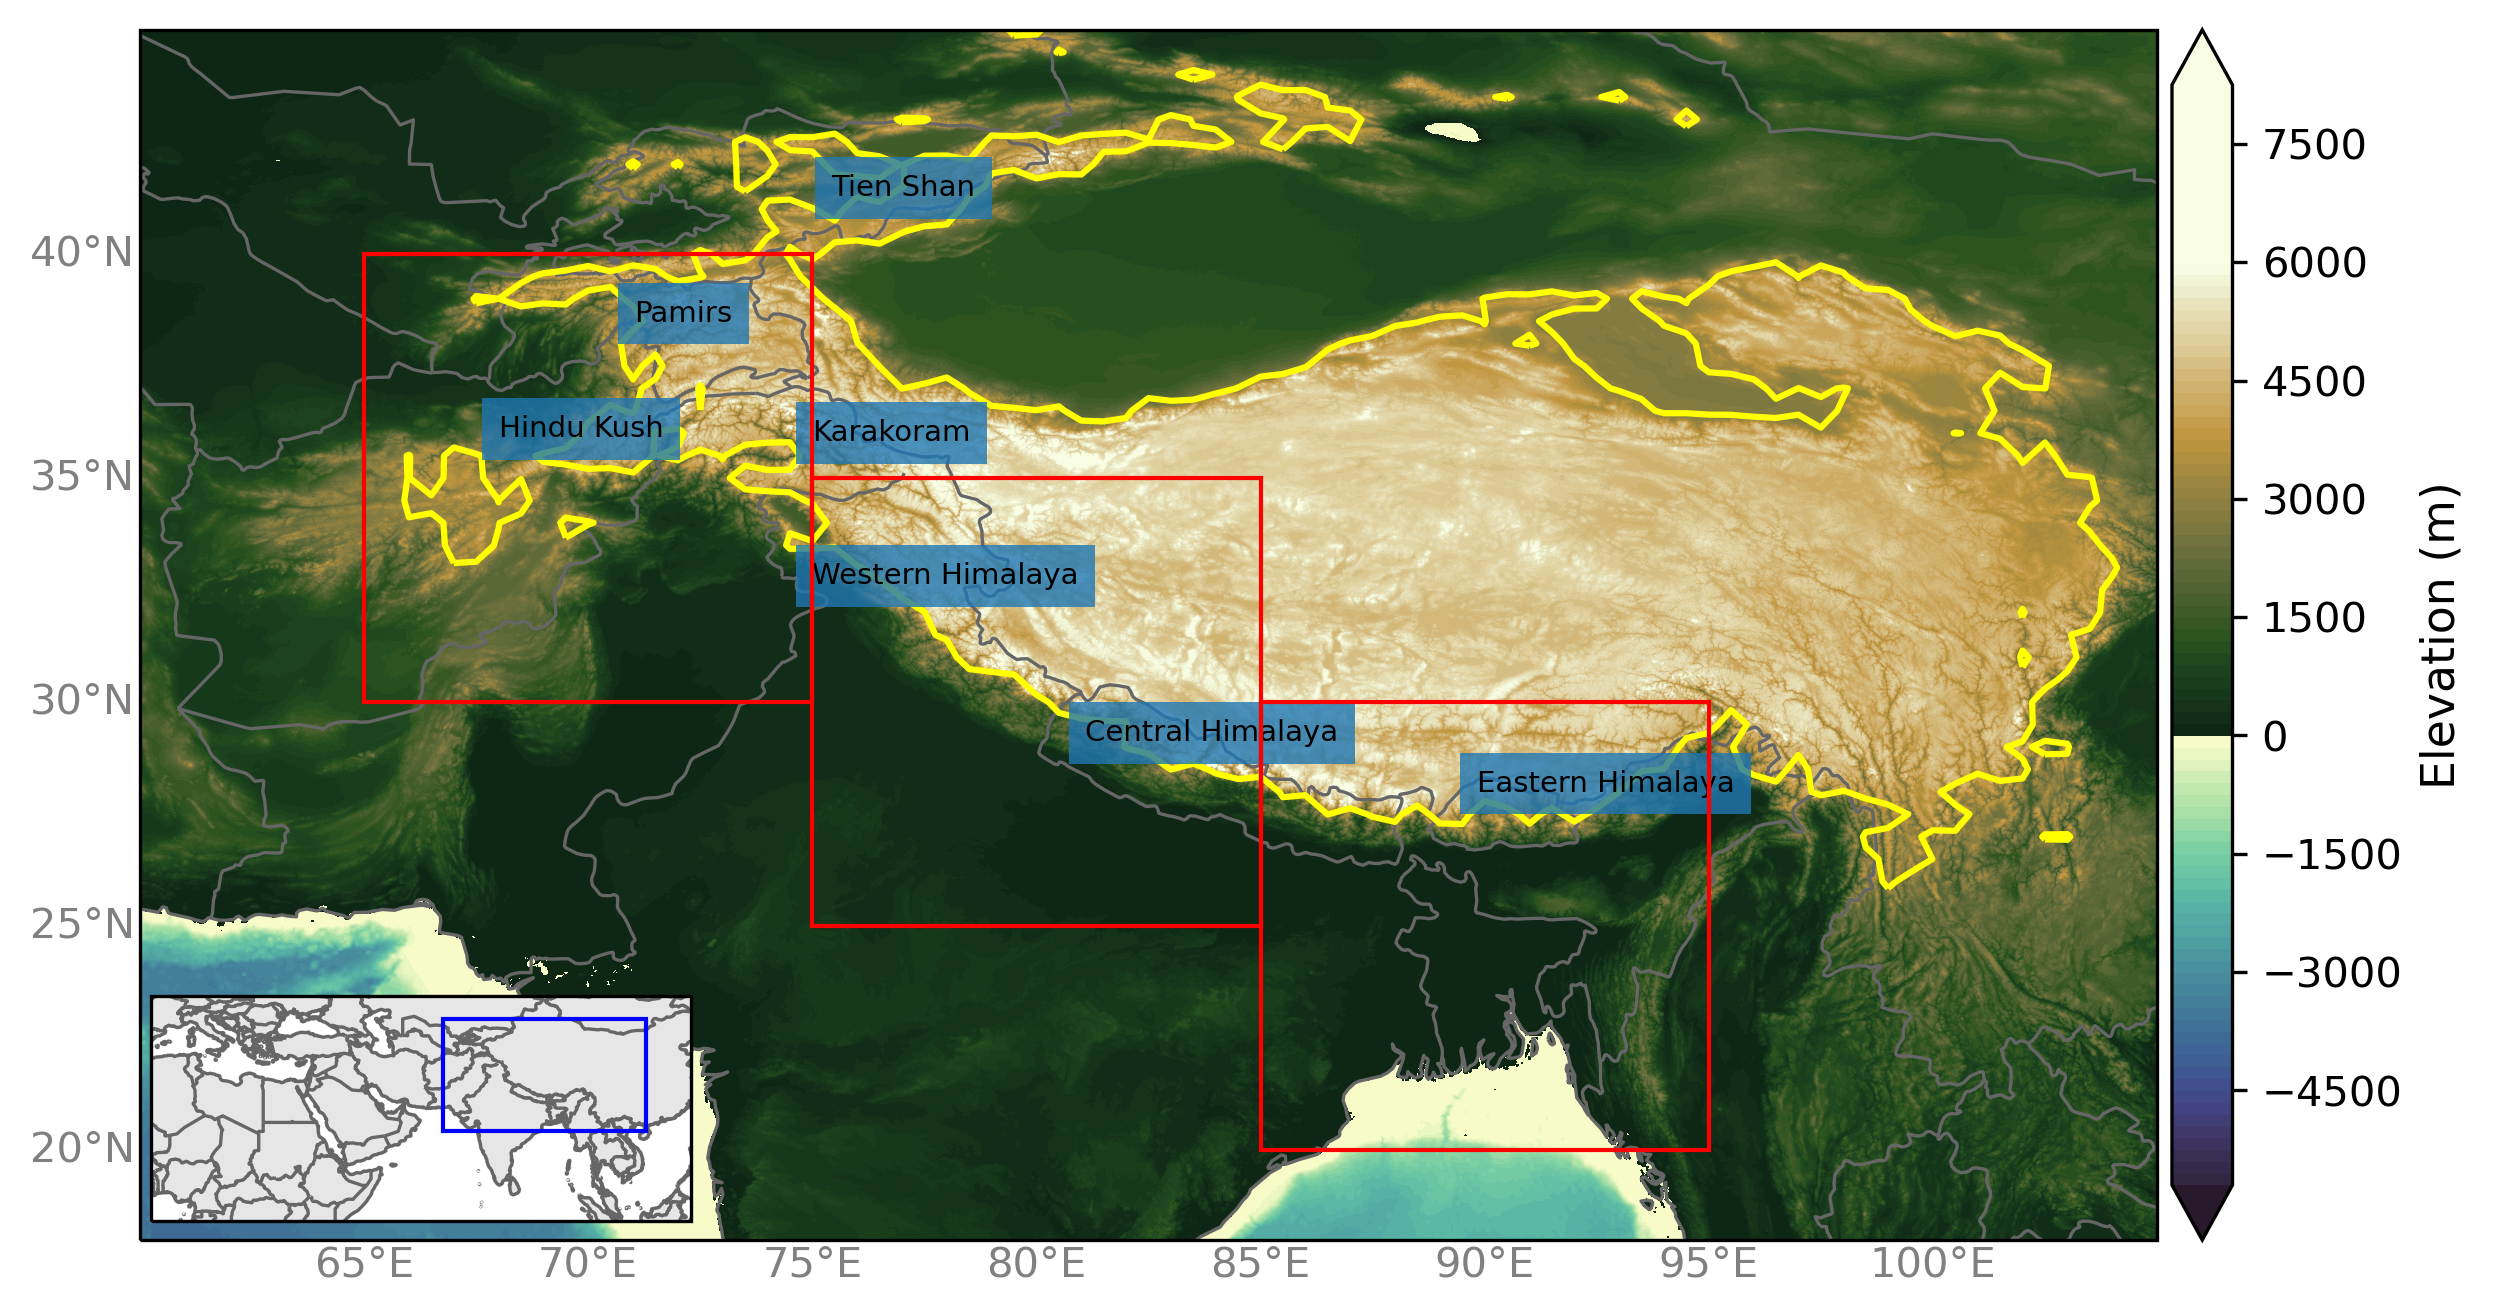

In [21]:
# Create figure
fig = plt.figure(figsize=(9, 8))
fig.dpi = 300
fname = path_to_figs + 'fig1_elevation_one-minute_with_inset'
fmt = 'png'

nrows = 1
ncols = 1
ext1 = [0, 120, 0, 50]
ext2 = [60, 105, 18, 45]
exts = [ext1, ext2]
# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.45,
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.05, cbar_size='3%',label_mode='')

# cmap setup
cmap = cmo.topo
# clipcmap = cmocean.tools.crop_by_percent(cmap, 5, which='both', N=None)
cflevs = np.arange(-6000, 6000, )

for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=ext2, xticks=dx, yticks=dy)

#     cf = ax.pcolormesh(lons, lats, topo, transform=datacrs, cmap=cmap, cbar_kwargs=dict(pad=0.01, aspect=30))
    
    cf = ax.contourf(lons, lats, topo, 100, cmap=cmap, 
                   transform=datacrs,
                   vmin=-6000, vmax=6000,extend="both")
    
    # Contour Lines (terrain)
    clevs=np.array([3000])
    cs = ax.contour(newlons, newlats, regrid_topo.bedrock, clevs, colors='yellow', linewidths=1.5,
                    linestyles='solid', transform=datacrs)

    # add subregions
    add_subregion_boxes(ax=ax, subregion_xy=sr_xy, width=sr_width, 
                        height=sr_height, ecolor='red', datacrs=datacrs)
    
    # add hasia labels
    add_hasia_labels(ax=ax, fntsize=12, txtcol='white')
        
    ### Add inset map  [left, bottom, width, height]
    axins = plt.axes([0.129, 0.255, 0.2, 0.1], projection=mapcrs)
    axins.set_extent(ext1, crs=datacrs)
    # Add map features (continents and country borders)
    axins.add_feature(cfeature.LAND, facecolor='0.9')      
    axins.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
    axins.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)


    axins.add_patch(mpatches.Rectangle(xy=[65., 20], width=45, height=25,
                                        fill=False,
                                        edgecolor='b',
                                        linewidth=1.0,
                                        transform=mapcrs,
                                        zorder=100))


# Colorbar (single)
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='vertical', drawedges=False)
cb.set_label('Elevation (m)', fontsize=11)
cb.ax.tick_params(labelsize=10)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()